## Imports

In [1]:
import numpy as np
import pandas as pd
import itertools
import random
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from ALWGAN_new_v1.Models import NN_phi,NN_h
from ALWGAN_new_v1.training import WAAL
from ALWGAN_new_v1.dataset_handler import myData
from ALWGAN_new_v1.Experiment_functions import time_execution,MAE,MAPE,display_prediction,display_chosen_labelled_datas,display_loss_t1,display_loss_t2,display_phi

from sklearn import datasets
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Preparing Data

#### Preparing boston

In [2]:
boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns = boston.feature_names)
df["target"]=boston.target

y_boston=df.target
X_boston=df.drop("target",axis=1)

#scaler = RobustScaler()
#X_boston=pd.DataFrame(scaler.fit_transform(X_boston)).set_axis(X_boston.columns, axis=1)
y_boston=torch.Tensor(y_boston).view(len(y_boston),1).float()
X_boston=torch.Tensor(X_boston.values).float()

C:\Users\matth\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

#### Preparing other functions

In [3]:
data_generated= 1000 #total data generated
proportion= 0.20 # proportion of dataset in testset

#Generate data
x= torch.tensor([[random.random()] for i in range(data_generated)])
y_carré=(0.5*x**2)

x_log=x+1
y_log=torch.log(x_log)

x_3dim= torch.tensor([[random.random(),random.random(),random.random()] for i in range(data_generated)])
y_3dim= torch.sum((1/(2*np.sqrt(3)))*x_3dim**2,1).view(data_generated,1)

x_hdim= torch.tensor(np.random.rand(data_generated,10)).float()
y_hdim= torch.sum((1/(2*np.sqrt(10)))*x_hdim**2,1).view(data_generated,1).float()

x_b=torch.tensor([random.random() for i in range(data_generated)])

x_log_b=(x_b+1).view(x.size()[0],1)
y_log_b=(torch.log(x_b+1)+ torch.tensor([np.random.normal(loc=0,scale=0.025) for i in range(data_generated)])).view(x.size()[0],1)

x_carré_b=x_b.view(x.size()[0],1)
y_carré_b=(0.5*x_b**2 + torch.tensor([np.random.normal(loc=0,scale=0.025) for i in range(data_generated)])).view(x.size()[0],1)

x_3dim_b= torch.tensor([[random.random(),random.random(),random.random()] for i in range(data_generated)])
y_3dim_b=(torch.sum((1/(2*np.sqrt(3)))*x_3dim_b**2,1)+ torch.tensor([np.random.normal(loc=0,scale=0.025) for i in range(data_generated)])).view(data_generated,1) 

x_hdim_b= torch.tensor(np.random.rand(data_generated,10)).float()
y_hdim_b= (torch.sum((1/(2*np.sqrt(10)))*x_hdim_b**2,1)+ torch.tensor([np.random.normal(loc=0,scale=0.025) for i in range(data_generated)])).view(data_generated,1).float()

x_hdimsin_b= torch.tensor(np.random.rand(data_generated,10)).float()
y_hdimsin_b= ((1/(4*np.sqrt(10)))*np.sin(4*torch.sum(x_hdimsin_b,1))+1+ torch.tensor([np.random.normal(loc=0,scale=0.008) for i in range(data_generated)])).view(data_generated,1).float()

#splitting
X_train,X_test,y_train,y_test=train_test_split(x_carré_b,y_carré_b,test_size=proportion)



#generating testset
testset=myData(X_test,y_test)

#For Boston
#scaler_test = RobustScaler()
#y_train=torch.Tensor(scaler_test.fit_transform(y_train))

#taking limited number of datas to make the query process run faster
X_train=X_train[:50]
y_train=y_train[:50]


### Full training function

In [4]:
def full_training(strategy,num_round,X_test,y_test,show_losses,freq_display_figures,show_unlabelled,show_estim_chosen):
    start=time.time()
    t1_descend_list=[]
    t2_ascend_list=[]
    acc = []# MAE
    acc_percentage=[] #MAPE
    for rd in range(1,num_round+1):

            print('\n================Round {:d}==============='.format(rd))

            t1_descend,t2_ascend=strategy.train(show_losses=show_losses)
            
            t1=list(map(lambda x: x.detach(),t1_descend))
            t2=list(map(lambda x: x.detach(),t2_ascend))
            t1_descend_list.append(t1)
            t2_ascend_list.append(t2)
            
            b_idxs = strategy.query()
            strategy.idx_lb[b_idxs] = True

            if(rd%freq_display_figures==0):
                #display_loss_t1(t1,rd)
                #display_loss_t2(t2,rd)
                display_phi(strategy.X_train,strategy.phi,rd)
                display_chosen_labelled_datas(strategy.X_train,strategy.idx_lb,strategy.y_train,b_idxs,rd,strategy.h
                                              ,show_unlabelled=show_unlabelled,show_estim_chosen=show_estim_chosen)
                display_prediction(X_test,strategy.h,y_test,rd)
                
                
                
                
            acc.append(MAE(X_test,y_test,strategy.h))
            acc_percentage.append(MAPE(X_test,y_test,strategy.h))
    
    print('\n================Final training===============')
    
    t1_descend,t2_ascend=strategy.train(show_losses=show_losses)
    t1=list(map(lambda x: x.detach(),t1_descend))
    t1_descend_list.append(t1)
    
    display_loss_t1(t1,rd)
    display_prediction(X_test,strategy.h,y_test,"final")
    
    
    acc.append(MAE(X_test,y_test,strategy.h))
    error_each_round=list(map(lambda x: x[0],acc))

    acc_percentage.append(MAPE(X_test,y_test,strategy.h))
    error_each_round_per=list(map(lambda x: x[0],acc_percentage))
    
    end=time.time()
    
    return start,end,error_each_round,error_each_round_per,t1_descend_list,t2_ascend_list

## Training one config


================Round 1===============
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

================Round 2===============


C:\Users\matth\jupyter codes\Recherche\ALWGAN_new_v1\training.py:156: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(losses)
C:\Users\matth\jupyter codes\Recherche\ALWGAN_new_v1\training.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(losses)


tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

================Round 3===============
tensor([0.])
tensor([0.])
tensor([4.6566e-10])
tensor([4.6566e-10])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([4.6566e-10])
tensor([4.6566e-10])
tensor([0.])
tensor([0.])
tensor([4.6566e-10])
tensor([0.])
tensor([0.

C:\Users\matth\jupyter codes\Recherche\ALWGAN_new_v1\Experiment_functions.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[9,6])
C:\Users\matth\jupyter codes\Recherche\ALWGAN_new_v1\Experiment_functions.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[9,6])



================Round 8===============
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])


C:\Users\matth\jupyter codes\Recherche\ALWGAN_new_v1\Experiment_functions.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[9,6])



================Round 9===============
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

================Round 10===============
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

================Round 11===============
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor(

C:\Users\matth\jupyter codes\Recherche\ALWGAN_new_v1\Experiment_functions.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[9,6])


'0h 0 min 10.251513481140137 s'

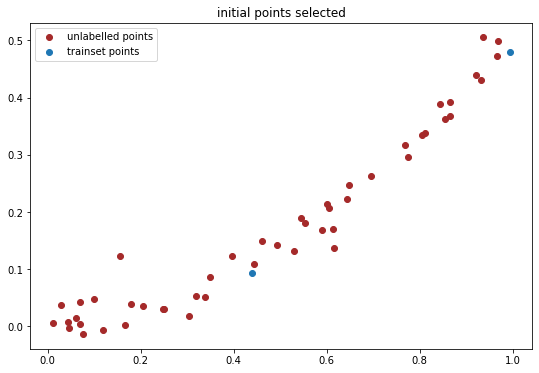

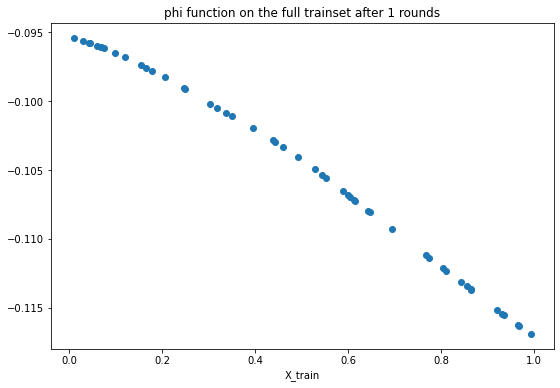

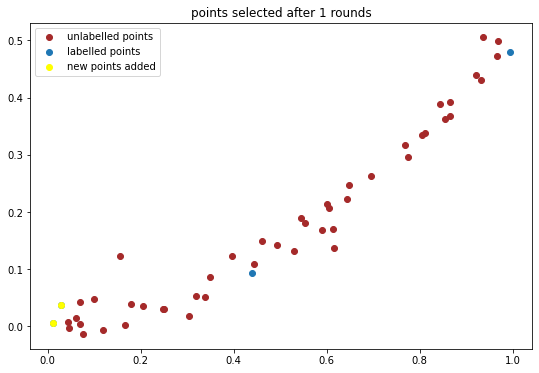

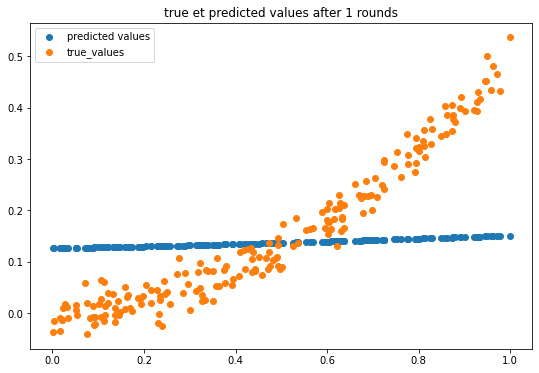

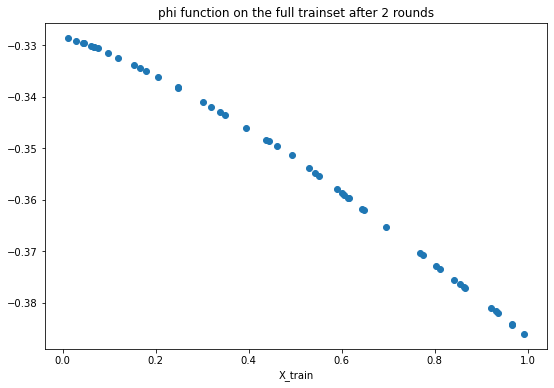

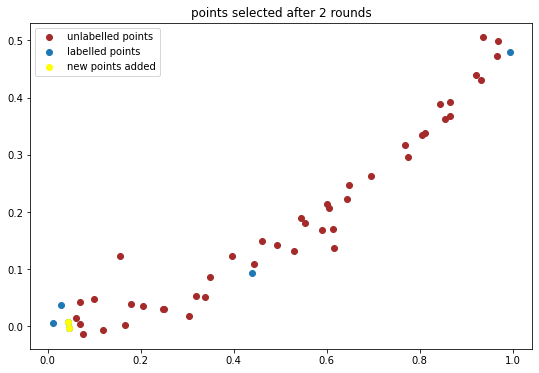

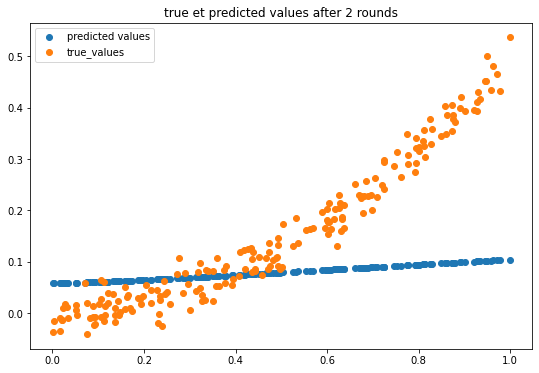

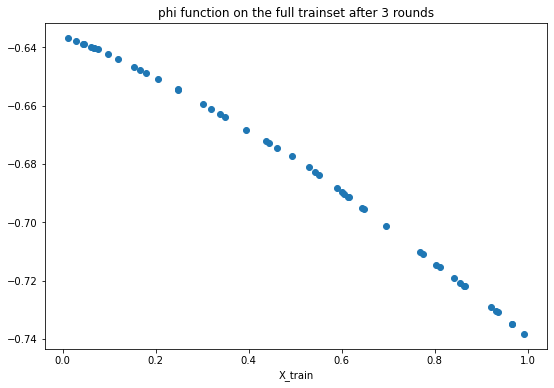

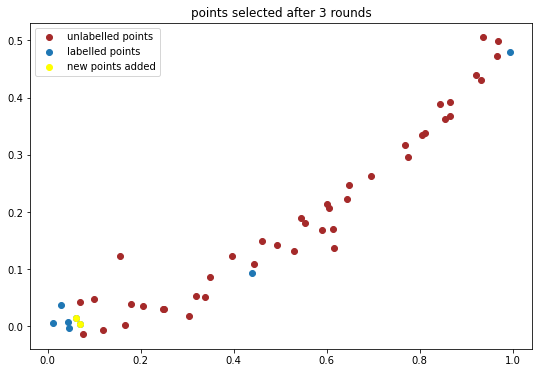

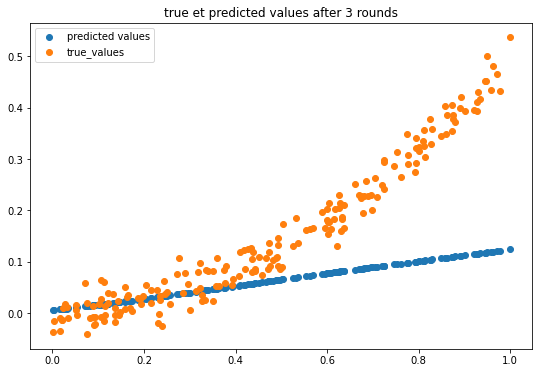

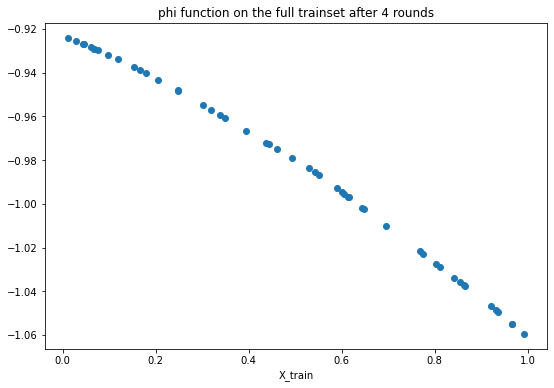

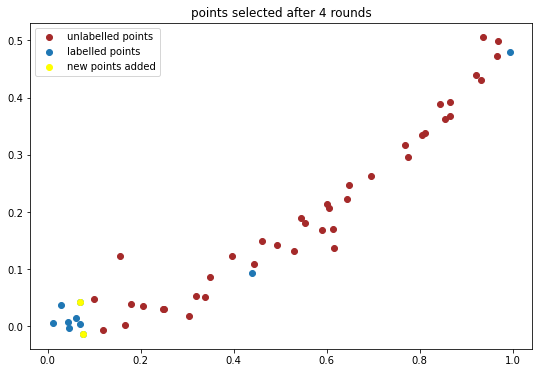

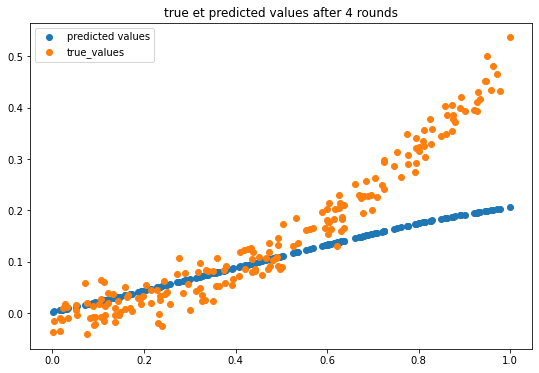

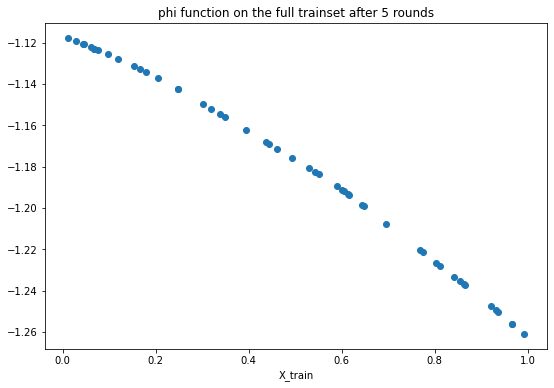

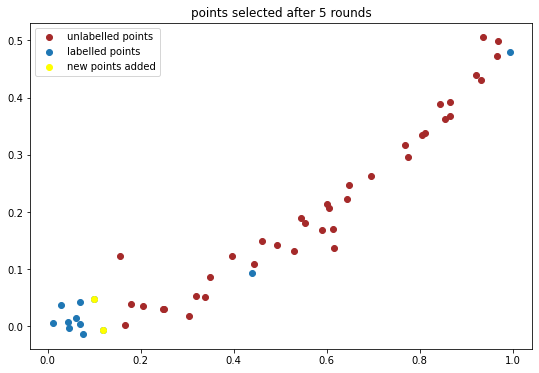

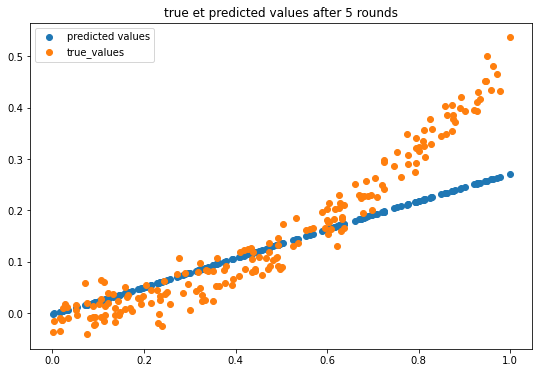

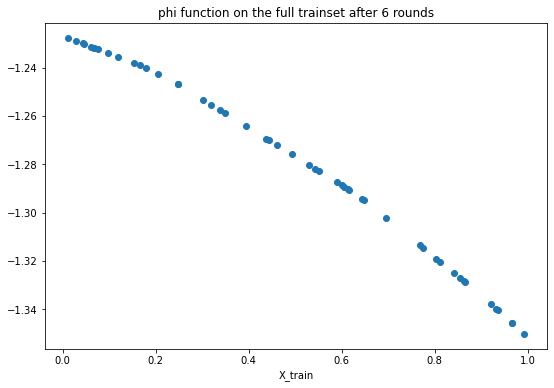

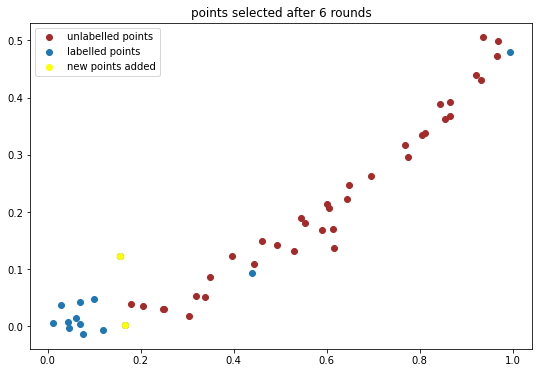

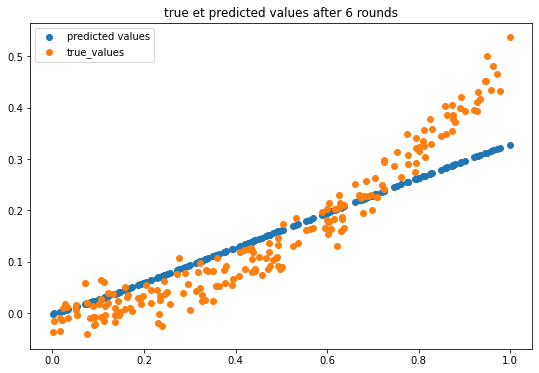

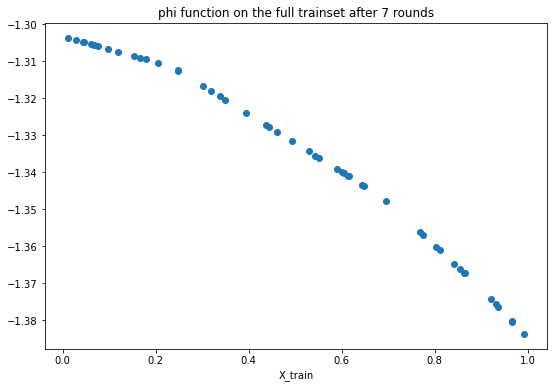

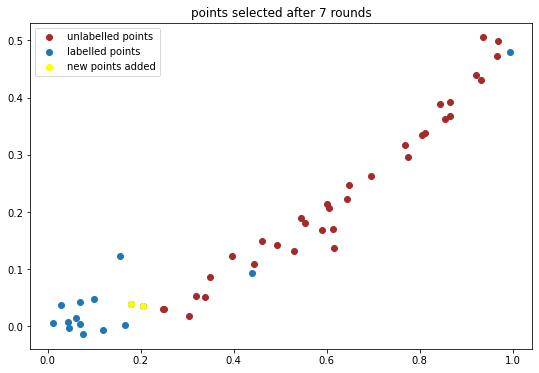

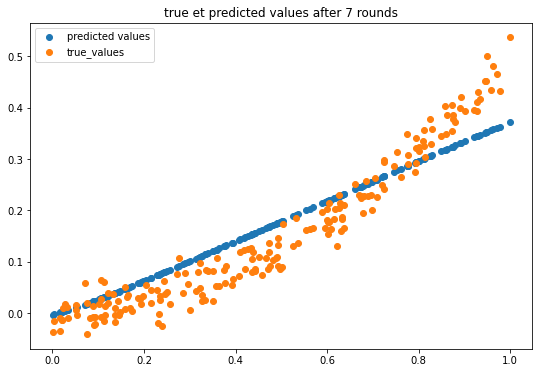

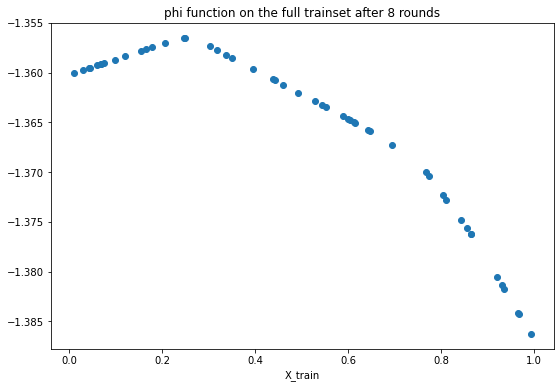

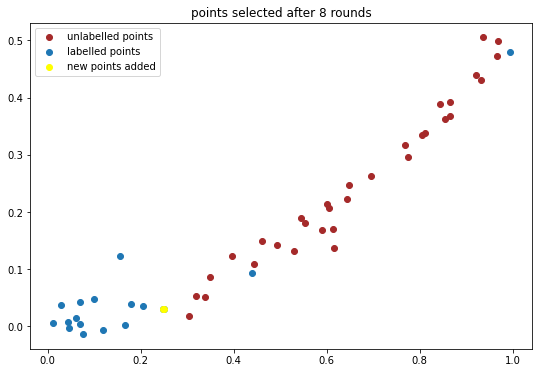

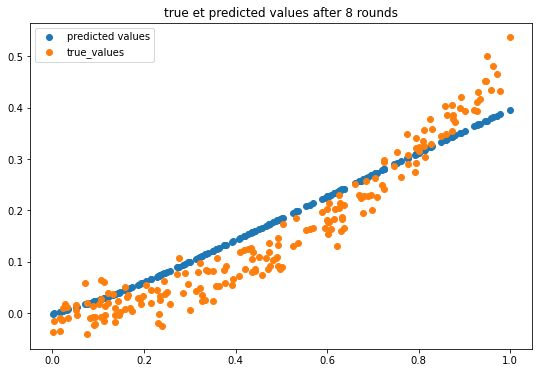

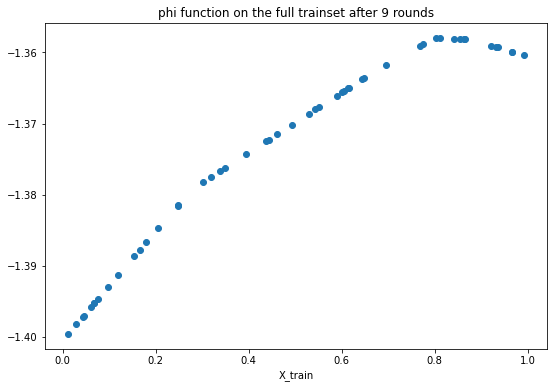

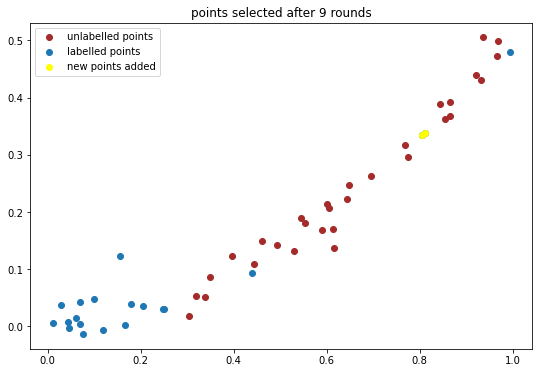

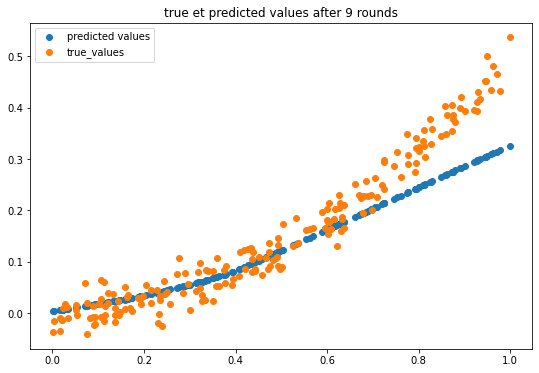

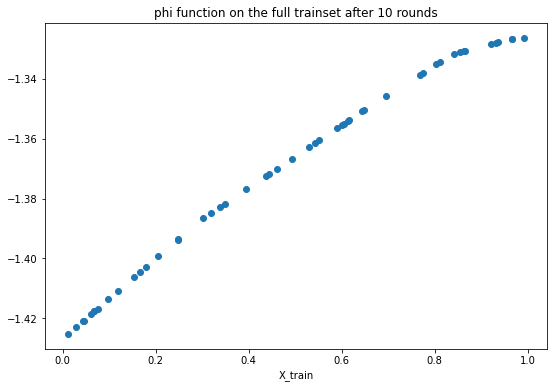

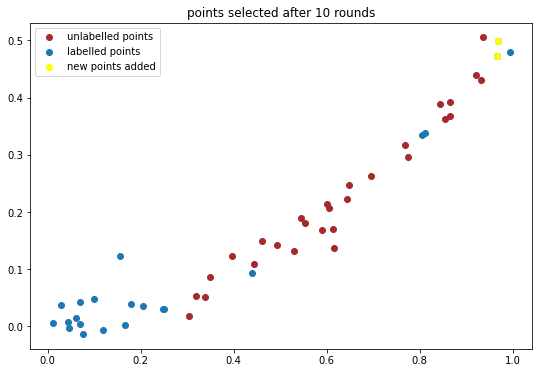

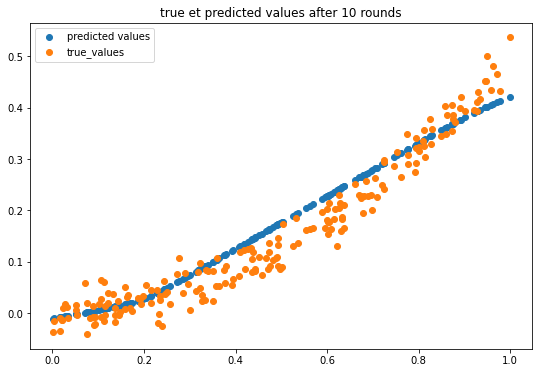

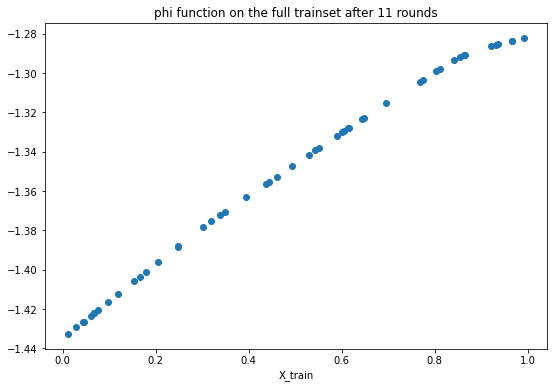

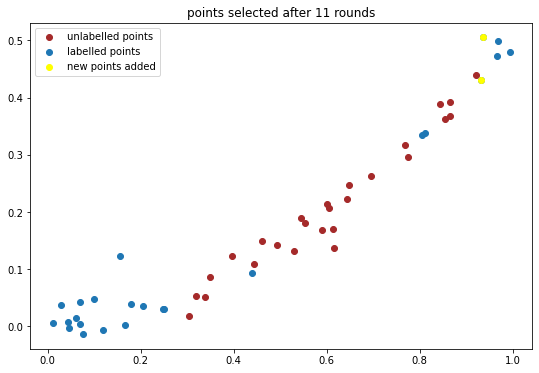

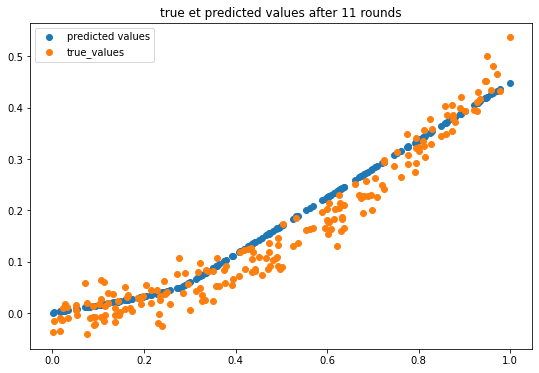

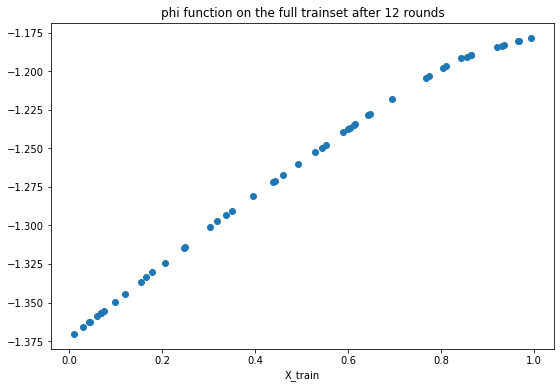

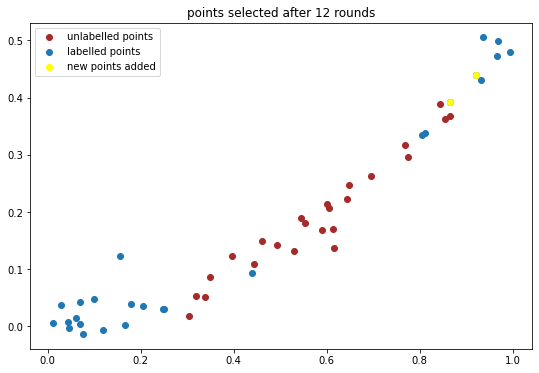

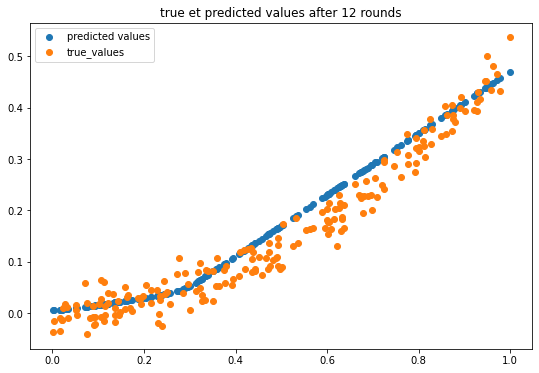

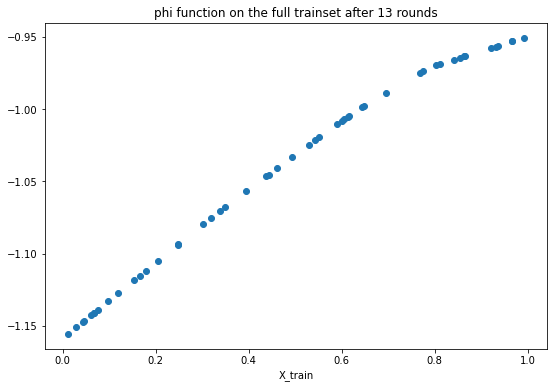

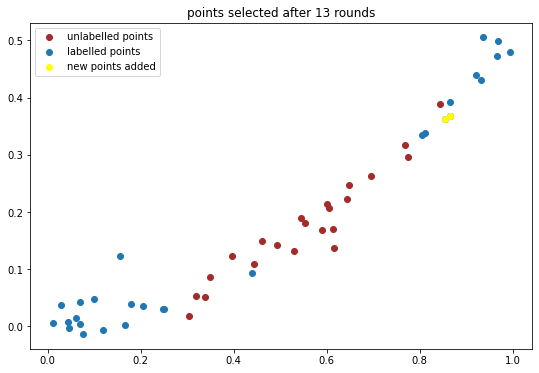

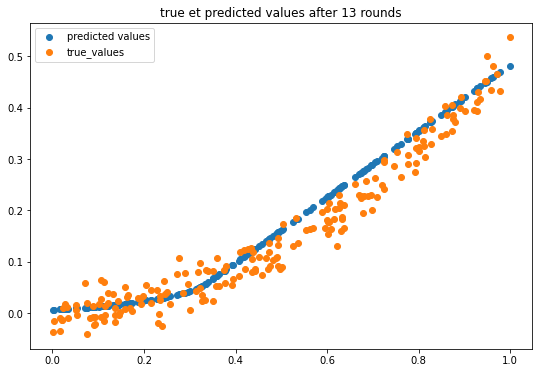

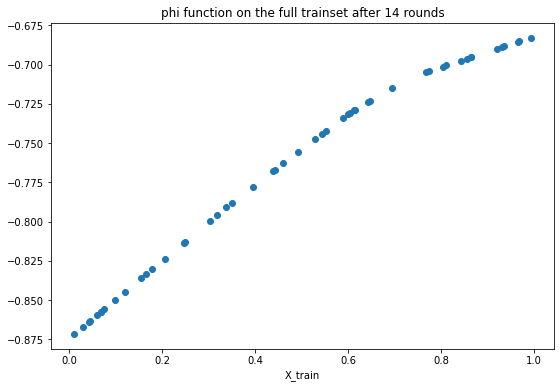

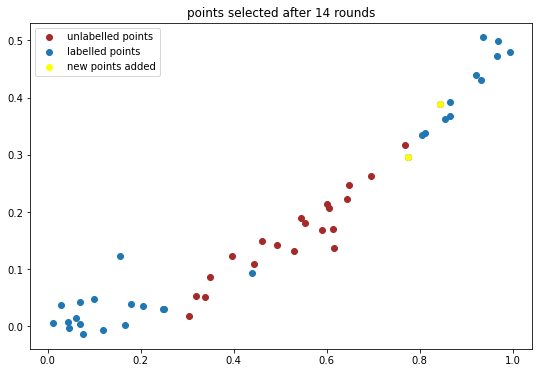

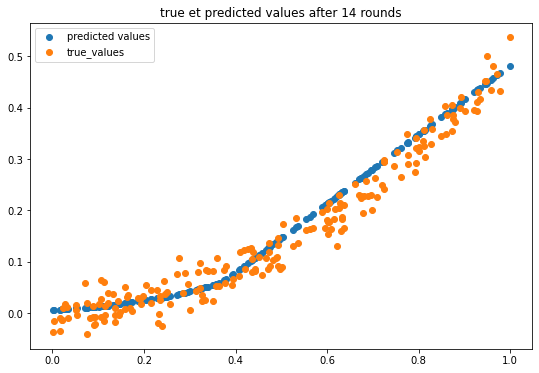

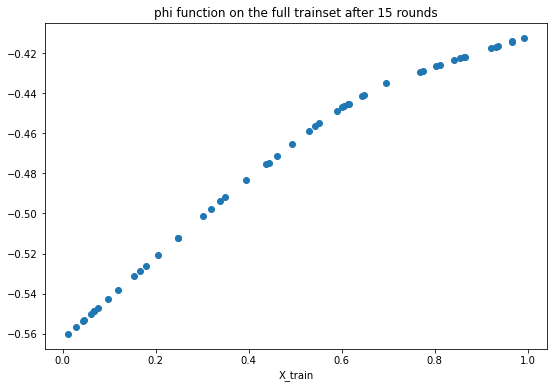

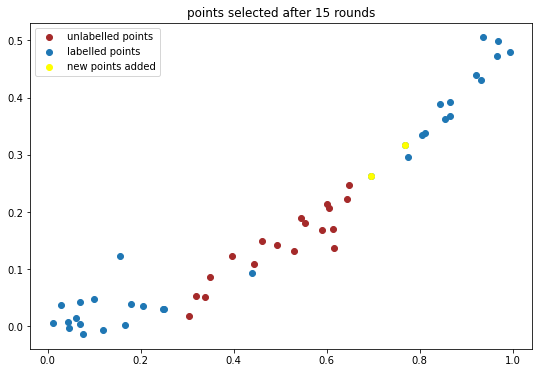

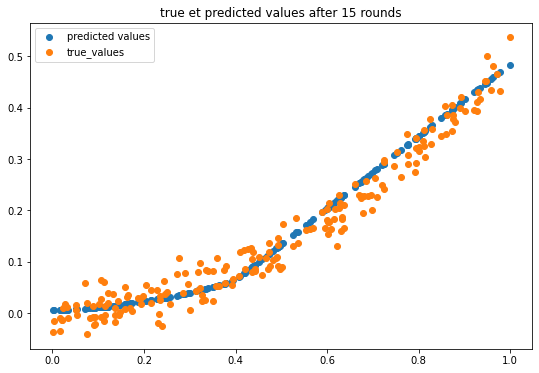

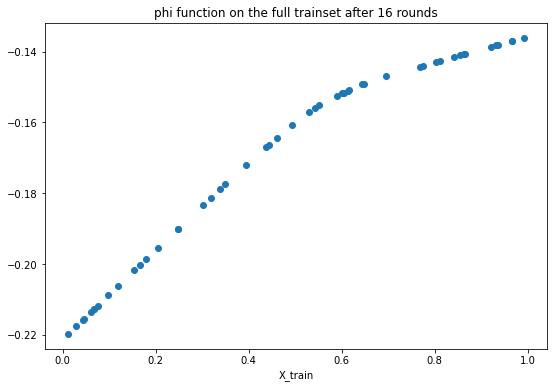

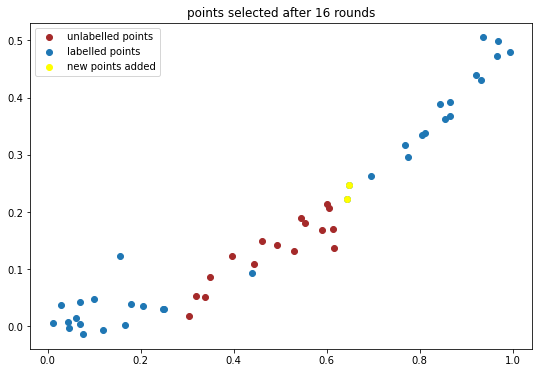

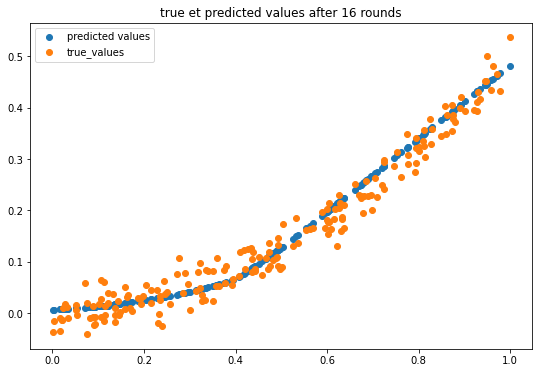

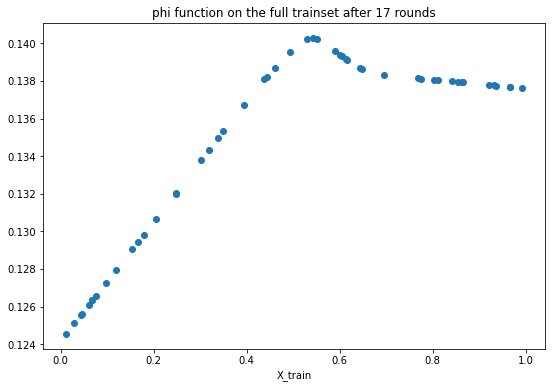

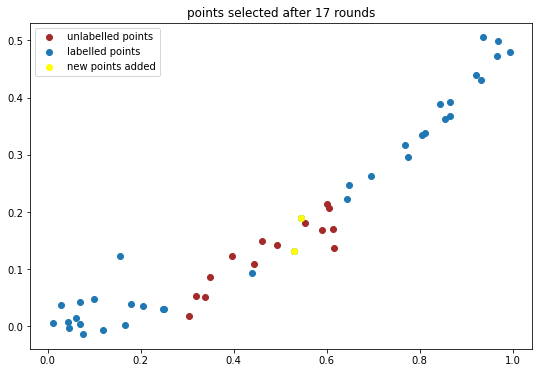

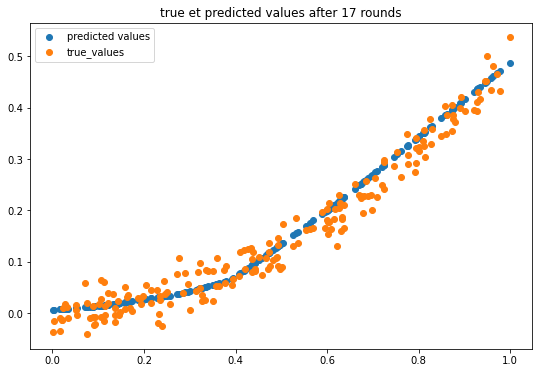

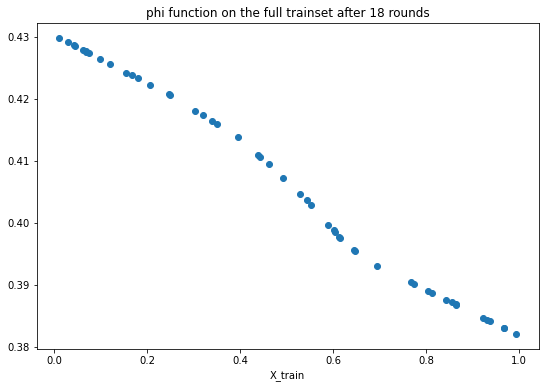

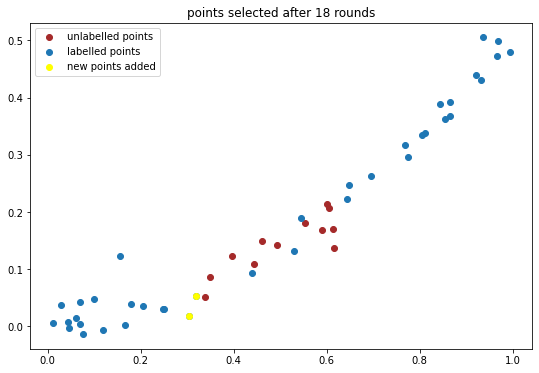

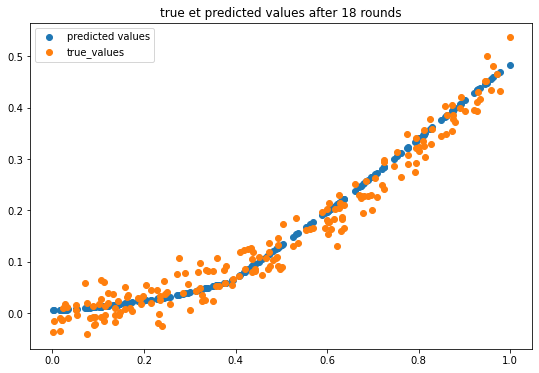

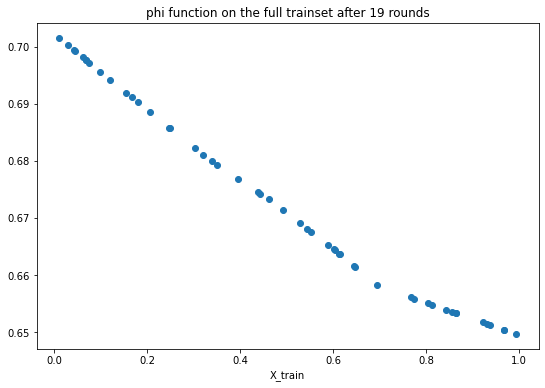

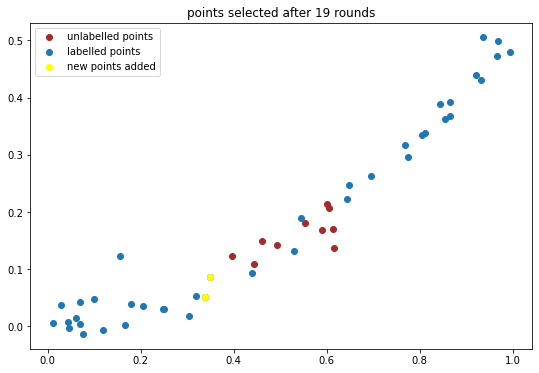

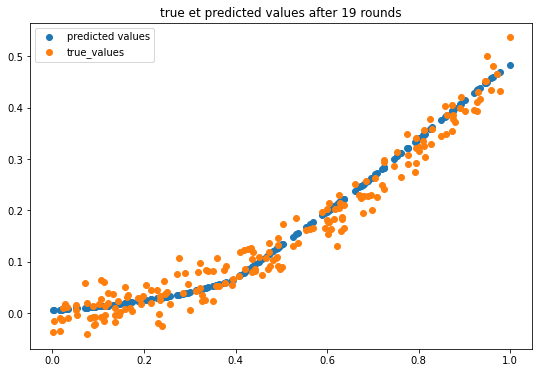

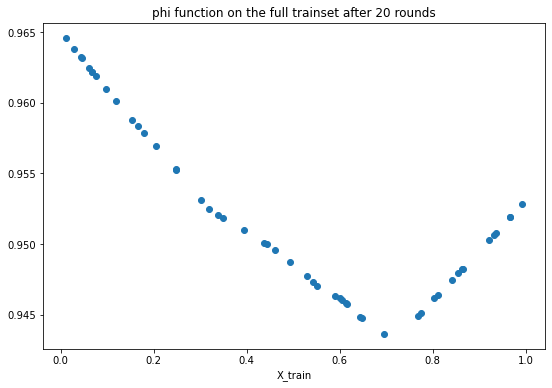

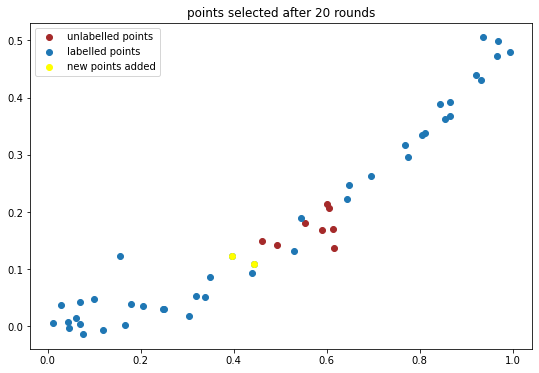

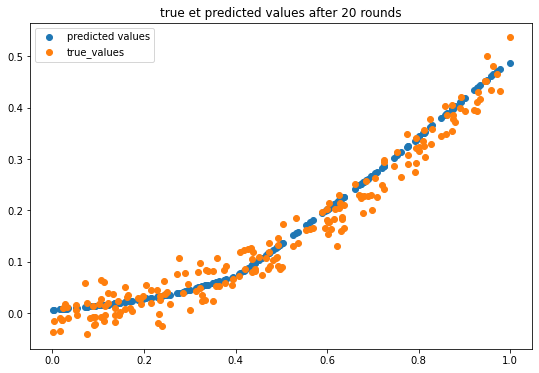

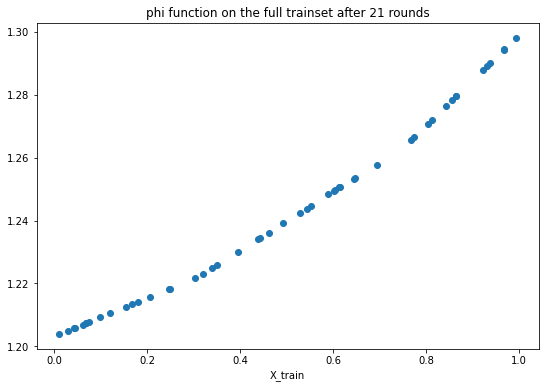

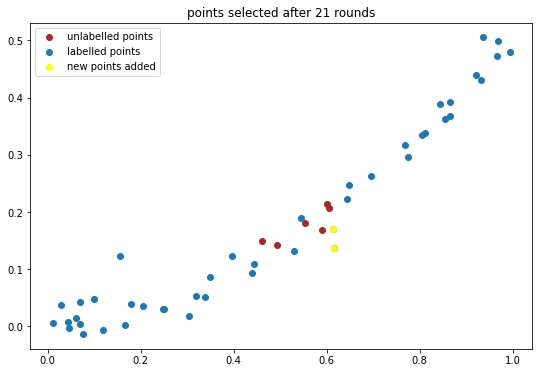

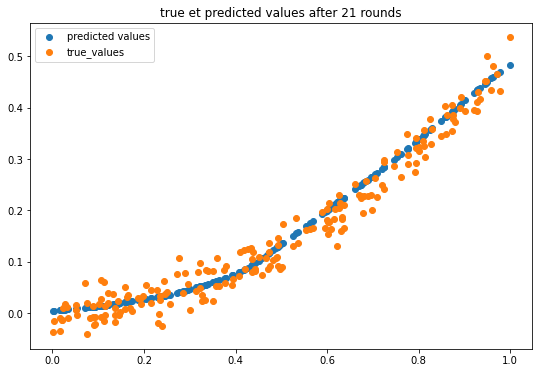

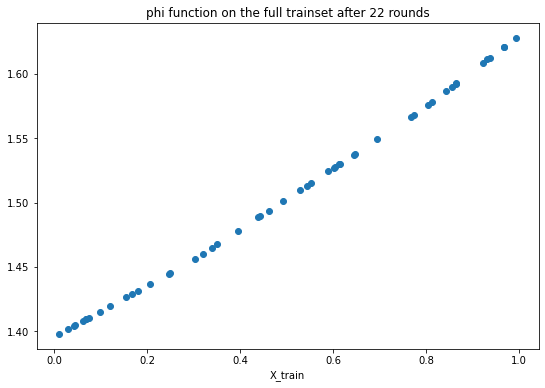

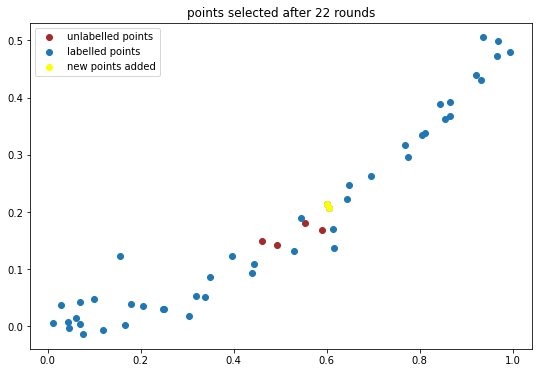

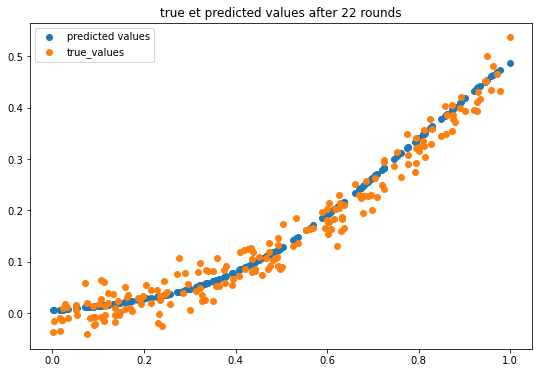

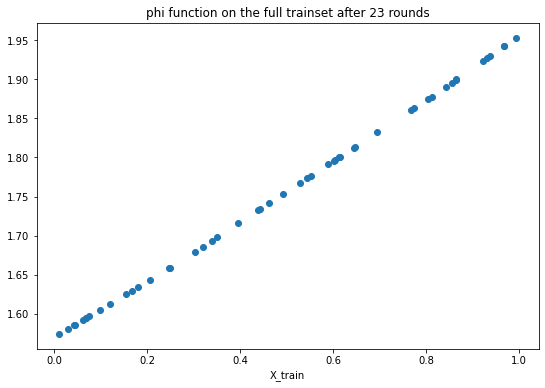

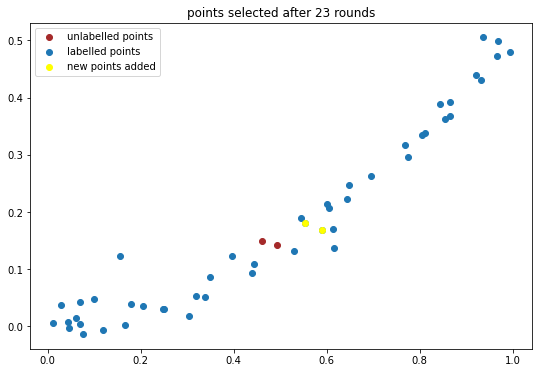

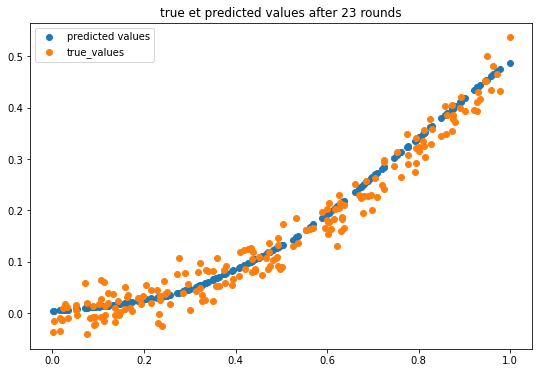

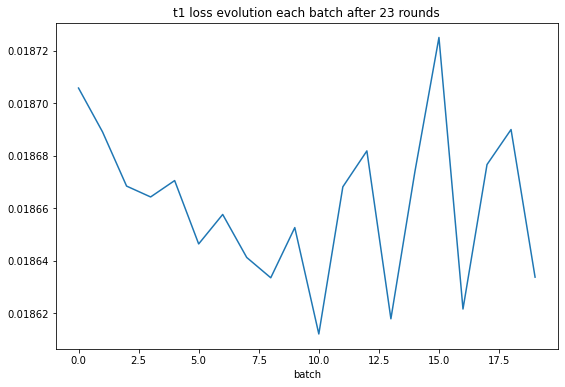

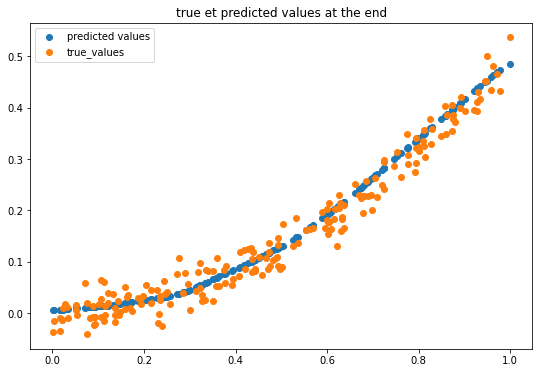

In [5]:
total_epoch_train=20 # number of epochs to train h and phi each round (1)
num_elem_queried= 2 # number of elem queried each round  (2)
nb_initial_labelled_datas = 2 #nb of labelled datas at round 0 (3)
lr=0.001             # learning rate  (4)
batch_size_train=len(X_train)  # size of the batch in the training process (5) #len(X_train)
dim_input=1

freq_display_figures=1
show_losses=False
show_unlabelled=True
show_estim_chosen=False

# number of rounds to use all the trainset: int(((1-proportion)*data_generated-nb_initial_labelled_datas)/num_elem_queried)
num_round=int((len(y_train)-nb_initial_labelled_datas)/num_elem_queried)-1  # number of rounds


# Generate the initial labeled pool
n_pool = len(y_train)
n_test = len(y_test)
idxs_lb = np.zeros(n_pool, dtype=bool)
idxs_tmp = np.arange(n_pool)
np.random.shuffle(idxs_tmp)
idxs_lb[idxs_tmp[:nb_initial_labelled_datas]] = True


display_chosen_labelled_datas(X_train,idxs_lb,y_train,b_idxs=None,rd=None,init=True,show_unlabelled=show_unlabelled)

phi=NN_phi(dim_input=dim_input,dim_output=1,norm="inf")
h=NN_h(dim_input=dim_input,dim_output=1,norm="inf")

opti_phi = optim.Adam(phi.parameters(), lr=lr)
opti_h = optim.Adam(h.parameters(), lr=lr)

strategy = WAAL(X_train,y_train,idxs_lb,total_epoch_train,batch_size_train,num_elem_queried,lr,phi,h,opti_phi,opti_h)
start,end,error_each_round,error_each_round_per,t1_descend_list,t2_ascend_list=full_training(
    strategy,num_round,X_test,y_test,show_losses,freq_display_figures,show_unlabelled,show_estim_chosen)


print("\n\n")

time_execution(start,end) 

Text(0.5, 1.0, 'T1 loss evolution each batch')

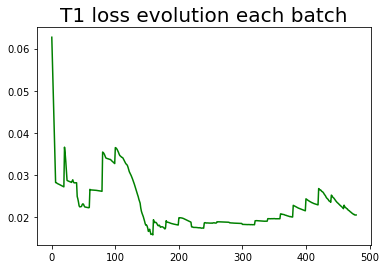

In [6]:
plt.plot(list(itertools.chain(*t1_descend_list)),c="green")
plt.title("T1 loss evolution each batch",fontsize=20)

Text(0.5, 1.0, 'T2 loss evolution each batch')

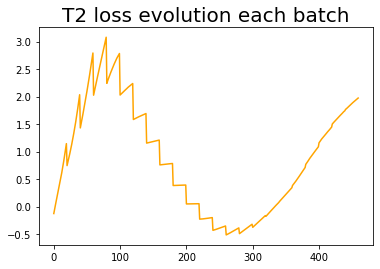

In [7]:
plt.plot(-np.array(list(itertools.chain(*t2_ascend_list))),c="orange")
plt.title("T2 loss evolution each batch",fontsize=20)

Text(0.5, 1.0, 'mean absolute error of h each rounds')

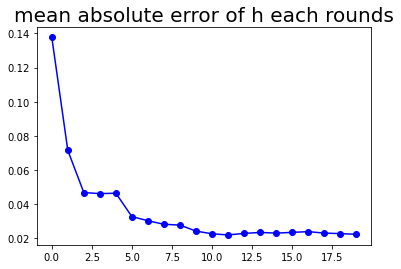

In [7]:
plt.plot(error_each_round,marker="o",c="b")
plt.title("mean absolute error of h each rounds",fontsize=20)

Text(0.5, 1.0, 'mean absolute percentage error of h each rounds')

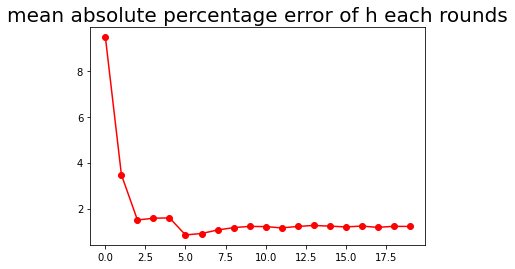

In [8]:
plt.plot(error_each_round_per,marker="o",c="r")
plt.title("mean absolute percentage error of h each rounds",fontsize=20)

## Training different configurations and save MAE,MAPE and duration of execution in excel

In [ ]:
total_epoch_train_liste=[2,5,10,30,50]   # number of epochs to train h and phi each round (1)
#[2,5,10,30,50]
num_elem_queried_liste= [2,4,8,20]                # number of elem queried each round  (2)
#[2,4,8,20] 
nb_initial_labelled_datas_liste = [2,5,10,20] #nb of labelled datas at round 0 (3)
#[2,5,10,20]
lr=0.001                                   # learning rate  (4)
batch_size_train=len(X_train)                     # size of the batch in the training process (5)
dim_input=1

freq_display_figures=1 #1 if diplay all rounds
show_losses=True
liste_configs = [total_epoch_train_liste,num_elem_queried_liste,nb_initial_labelled_datas_liste]
combinations = [config for config in itertools.product(*liste_configs)]

duration_configs=[]
for total_epoch_train,num_elem_queried,nb_initial_labelled_datas in combinations:
    
    print(f"\nconfig: total_epoch_train: {total_epoch_train},num_elem_queried: {num_elem_queried},nb_initial_labelled_datas: {nb_initial_labelled_datas}\n")
    
    # number of rounds to use all the trainset: int(((len(y_train)-nb_initial_labelled_datas)/num_elem_queried)
    num_round=int((len(y_train)-nb_initial_labelled_datas)/num_elem_queried)-1  # number of rounds

    # Generate the initial labeled pool
    n_pool = len(y_train)
    n_test = len(y_test)
    idxs_lb = np.zeros(n_pool, dtype=bool)
    idxs_tmp = np.arange(n_pool)
    np.random.shuffle(idxs_tmp)
    idxs_lb[idxs_tmp[:nb_initial_labelled_datas]] = True


    phi=NN_phi(dim_input=dim_input,dim_output=1,norm="inf")
    h=NN_h(dim_input=dim_input,dim_output=1,norm="inf")

    opti_phi = optim.Adam(phi.parameters(), lr=lr)
    opti_h = optim.Adam(h.parameters(), lr=lr)

    strategy = WAAL(X_train,y_train,idxs_lb,total_epoch_train,batch_size_train,num_elem_queried,lr,phi,h,opti_phi,opti_h)

    start,end,error_each_round,error_each_round_per,t1_descend_list,t2_ascend_list=full_training(strategy,num_round,X_test,y_test,freq_display_figures)
    
    duration_configs.append(time_execution(start,end))

    
    df_temp = pd.DataFrame({"MAE":error_each_round,"MAPE":error_each_round_per})
    

    with pd.ExcelWriter("C:/Users/matth/Desktop/cours et TD en tout genre_A4/parcours recherche/results WAAL/outputWAAL_boston_hid_depth=6_size=128(total_epoch_train,num_elem_queried,nb_initial_labelled_datas,lr,batch_size_train).xlsx",
                        mode='a',engine="openpyxl") as writer:  
        df_temp.to_excel(writer
                         ,sheet_name=f"""boston,{total_epoch_train},{num_elem_queried},{nb_initial_labelled_datas},{lr},{batch_size_train}""")
        
df_duration_configs=pd.DataFrame({"time needed": duration_configs,"configuration":combinations})

with pd.ExcelWriter("C:/Users/matth/Desktop/cours et TD en tout genre_A4/parcours recherche/results WAAL/outputWAAL_boston_hid_depth=6_size=128(total_epoch_train,num_elem_queried,nb_initial_labelled_datas,lr,batch_size_train).xlsx",
                        mode='a',engine="openpyxl") as writer:  
        df_duration_configs.to_excel(writer
                         ,sheet_name="df_duration_configs")
        
       


config: total_epoch_train: 2,num_elem_queried: 2,nb_initial_labelled_datas: 2

================Round 1===============
================Round 2===============
================Round 3===============
================Round 4===============
================Round 5===============
================Round 6===============
================Round 7===============
================Round 8===============
================Round 9===============
================Round 10===============
================Round 11===============
================Round 12===============


<ipython-input-13-a950b9dae0ff>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[9,6])


================Round 13===============
================Round 14===============
================Round 15===============
================Round 16===============
================Round 17===============
================Round 18===============
================Round 19===============
================Round 20===============
================Round 21===============
================Round 22===============
================Round 23===============
0h 0 min 4.501191854476929 s

config: total_epoch_train: 2,num_elem_queried: 2,nb_initial_labelled_datas: 5

================Round 1===============
================Round 2===============
================Round 3===============
================Round 4===============
================Round 5===============
================Round 6===============
================Round 7===============
================Round 8===============
================Round 9===============
================Round 10===============
================Round 11===============
================Roun